# Наиболее точно (с точки зрения MAE) предсказать стоимость квартир
## Студент: Timur Taziev

| Название файла        | Описание                                       |
|-----------------------|------------------------------------------------|
| flat_prices_train.csv | Обучающий датасет                              |
| flat_prices_test.csv  | Тестовый датасет                               |
| sample_submission.csv | Пример файла, который нужно отправлять      |

# 1 этап: Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import lightgbm as lgb

data = pd.read_csv('flatprices_train.csv',sep=';')
test = pd.read_csv('flatprices_test.csv',sep=';')
data = data.drop_duplicates()

# 2 этап: Обзор данных

In [2]:
# Сводная информация по данным
lst = []
for name in data.columns:
    nu = len(data[name].unique())
    nisnan = data[name].isnull().sum()
    min_val = data[name].min()
    max_val = data[name].max()
    values_sample = data[name].unique()[:min(nu, 10)].tolist()
    lst.append([name, nu, nisnan, values_sample, min_val, max_val])

pd.DataFrame(lst, columns=['column', 'nunique', 'nnull', 'values', 'min', 'max'])


,column,nunique,nnull,values,min,max
0,id,14874,0,"[593048, 595253, 593535, 581671, 585873, 58651...",573521,597152
1,number_of_rooms,9,0,"[4, 2, 1, 3, 0, 5, 6, 7, 28]",0,28
2,floor_number,31,0,"[2, 6, 1, 13, 3, 5, 8, 7, 23, 9]",-2,89
3,number_of_floors,29,0,"[3, 9, 5, 17, 21, 25, 11, 15, 14, 6]",0,28
4,exploitation_start_year,98,8325,"[nan, 1977.0, 1969.0, 1962.0, 2007.0, 1973.0, ...",1898.0,2019.0
5,longitude,7022,0,"[44.01797, 43.873486, 44.010858278354, 44.0156...",43.6168,44.128352
6,latitude,6985,0,"[56.327522, 56.337276, 56.31019295, 56.266217,...",56.157439,56.392592
7,total_square,1631,0,"[160.0, 47.6, 41.5, 40.4, 30.1, 99.9, 44.0, 97...",0.0,527.0
8,living_square,702,0,"[100.0, 28.4, 28.0, 21.5, 0.0, 57.7, 30.0, 54....",0.0,304.0
9,kitchen_square,336,0,"[20.0, 6.2, 6.0, 9.8, 0.0, 16.9, 15.7, 9.1, 14...",0.0,100.0


# 3 этап: Обработка данных

In [3]:
# создание и удаление признаков
labelEncoder = LabelEncoder()
data['source_encoded'] = labelEncoder.fit_transform(data['source'])
test['source_encoded'] = labelEncoder.fit_transform(test['source'])
data['age'] = 2023 - data['exploitation_start_year']
test['age'] = 2023 - test['exploitation_start_year']
data = data.drop(['created_at','source','exploitation_start_year'], axis=1)
test = test.drop(['created_at','source','exploitation_start_year'], axis=1)

In [17]:
# работа с выбросами
data.loc[data['floor_number'] >= 89, 'floor_number'] = data['floor_number'].mean().round(0).astype('int64')
data.loc[data['floor_number'] < 1,   'floor_number'] = data['floor_number'].mean().round(0).astype('int64')
data.loc[data['total_square'] > 300, 'total_square'] = data['total_square'].mean().round(0).astype('int64')

# верхний порог количество комнат заменяем на 6
data.loc[data['number_of_rooms'] > 6, 'number_of_rooms'] = 6
test.loc[test['number_of_rooms'] > 6,'number_of_rooms'] = 6

# верхний порог возраста дома заменяем на 75 квантиль
data.loc[data['age'] > 90, 'age'] = data['age'].quantile(0.75).round(0).astype('int64')

# Заменяем выбросы таргета на среднее значение датафрейма
data.loc[data['price'] < data['price'].quantile(0.001), 'price'] = data['price'].mean().round(0).astype('int32')
data.loc[data['price'] > data['price'].quantile(0.999), 'price'] = data['price'].mean().round(0).astype('int32')

all_features = data.drop(['id','price'],axis = 1).columns
target = ['price']

# 4 Этап: Визуализаця

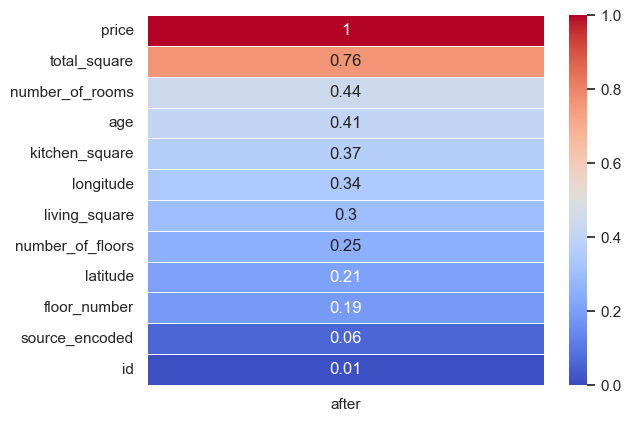

In [5]:
# корреляция с целевой переменной
correlations = data.corrwith(data['price']).abs().round(2).sort_values(ascending=False)
correlation_df = pd.DataFrame(correlations, columns=['after'])

sns.set_theme(style="darkgrid")
sns.heatmap(data=correlation_df, annot=True, 
            cmap="coolwarm",
            vmin=0,
            vmax=1, 
            linewidths=0.5,
            annot_kws={"size": 12})

plt.show()


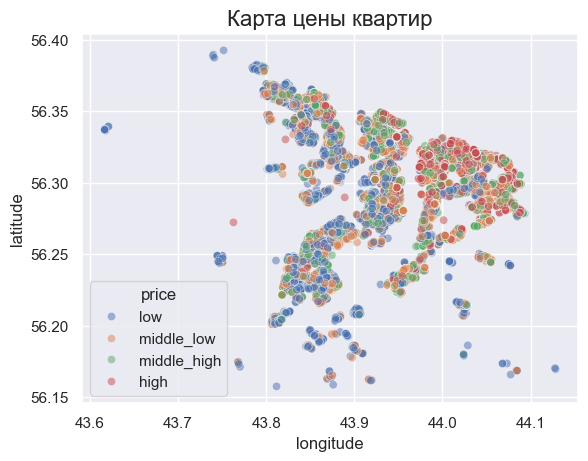

In [6]:
# Создание квантилей
quantile_labels = ['low', 'middle_low', 'middle_high', 'high']
price_class = pd.qcut(data['price'], q=[0, 0.25, 0.5, 0.75, 1], labels=quantile_labels)

# Создание scatterplot для оценки стоимости домов на карте
sns.scatterplot(data=data, y ='latitude' ,x ='longitude', hue=price_class, alpha=0.5)
plt.title('Карта цены квартир', fontsize=16)
plt.show()


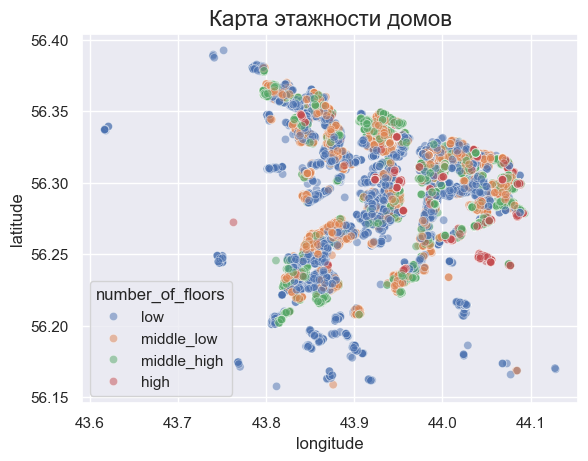

In [7]:
quantile_of_floors = pd.qcut(data['number_of_floors'], q=[0, 0.25, 0.5, 0.75, 1], labels=quantile_labels)

# Создание scatterplot для оценки этажности домой на карте
sns.scatterplot(data=data, y ='latitude' ,x ='longitude', hue=quantile_of_floors, alpha=0.5)
plt.title('Карта этажности домов', fontsize=16)
plt.show()


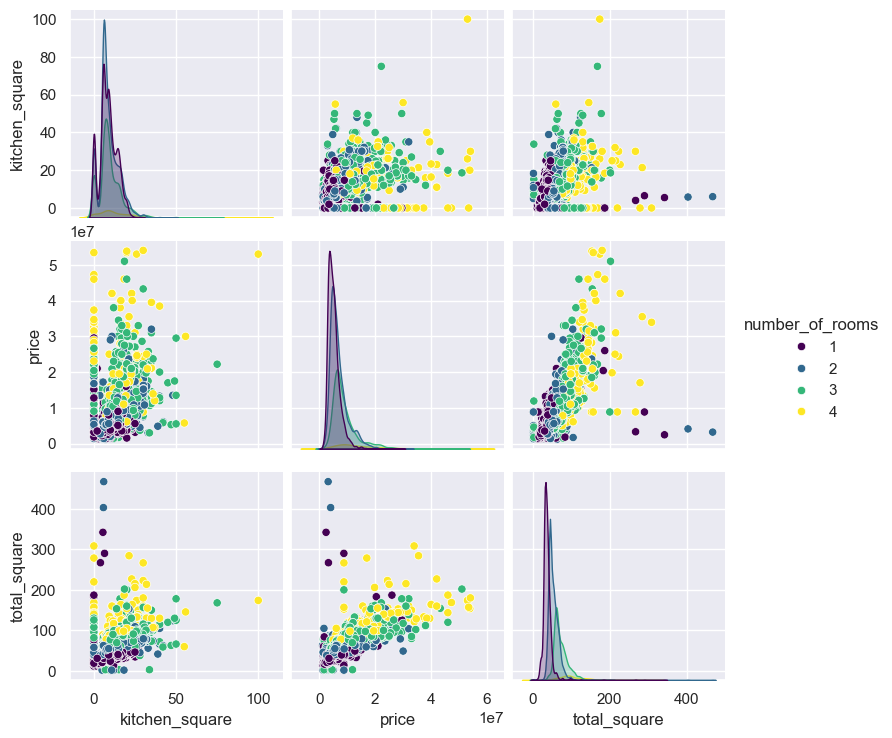

In [8]:
# быстрый взгляд на связи топ признаков
top_features = data[(data['number_of_rooms'] < 5) & (data['number_of_rooms'] > 0)].corrwith(data['price']).sort_values(ascending=False)[:4].index
selected_data = data[(data['number_of_rooms'] < 5) & (data['number_of_rooms'] > 0)][top_features.union(['price'])]

sns.pairplot(selected_data,hue='number_of_rooms',palette='viridis');

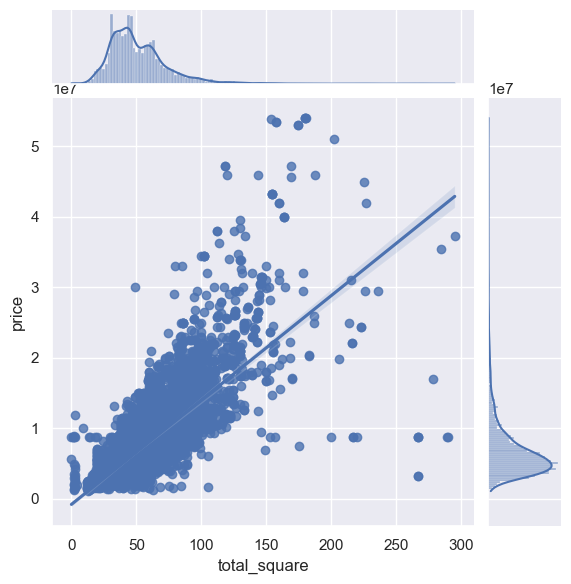

In [16]:
# линейная зависимость топ признака с таргетом
g2 = sns.jointplot(x='total_square', y='price', data=data[data['total_square'] < 300], kind='reg')

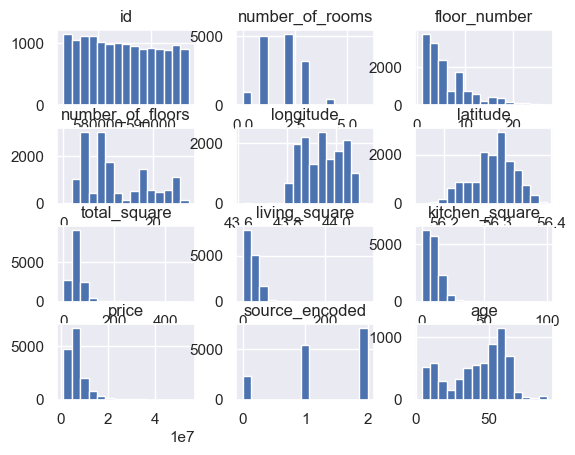

In [10]:
# графики распределения признаков
data.hist(bins=15);

# 5 этап: Preprocessing признаков

In [11]:
all_features = data.drop(['id','price'],axis = 1).columns
target = ['price']

#   Для непрерывных - применяем SimpleImputer, а затем StandardScaler
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("scaler", StandardScaler())
])

# Собираем воедино трансформеры для признаков
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, all_features) ])

# Создание конвейера препроцессора, который сначала преобразует данные
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

# 6 этап: Построение и тестирование Модели

In [12]:
# оптимальные гиперпараметры для моделей, заранее эти модели програл в GridSearchCV 
gradient_params = {'alpha': 0.1,     'learning_rate':  0.2, 'subsample': 0.8,      'loss': 'huber',
                   'max_depth': 7,   'min_samples_leaf': 1,'min_samples_split': 10,'n_estimators': 200 }
forest_params =   {'max_depth': None,'min_samples_leaf': 1,'min_samples_split': 2, 'n_estimators': 200 }

# отбор моделей которые будем использовать
estimators=[("random_forest",     RandomForestRegressor(**forest_params)),
            ("gradient_boosting", GradientBoostingRegressor(**gradient_params)),
            ("lgbm_regressor",    lgb.LGBMRegressor())]

# созданием модели
stacking_regression = StackingRegressor(estimators=estimators, final_estimator = GradientBoostingRegressor(), n_jobs=-1, verbose=True)
stacking_regression

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(n_estimators=200)),
                              ('gradient_boosting',
                               GradientBoostingRegressor(alpha=0.1,
                                                         learning_rate=0.2,
                                                         loss='huber',
                                                         max_depth=7,
                                                         min_samples_split=10,
                                                         n_estimators=200,
                                                         subsample=0.8)),
                              ('lgbm_regressor', LGBMRegressor())],
                  final_estimator=GradientBoostingRegressor(), n_jobs=-1,
                  verbose=True)

In [18]:
# создаем итоговую модель сделав preprocessing и выбрав модель
regression_pipeline = Pipeline(
steps=[("preprocessor", preprocessor), 
       ("regression",   stacking_regression)]) 

# делим train датасет на обучающую и тестовую выборку для определения mae и mse
x_train, x_test, y_train, y_test = train_test_split(data[all_features], data[target], test_size=0.2, random_state=42)
regression_pipeline.fit(x_train[all_features], np.ravel(y_train[target]))

preds_train = regression_pipeline.predict(x_train[all_features])
preds_test =  regression_pipeline.predict(x_test[all_features])

# округляем до целых чисел,так как значения большие и для простоты визуальной читаемости
a,b = round(sqrt(mean_squared_error(y_train[target], preds_train)),0), round(mean_absolute_error(y_train[target], preds_train),0)
c,d = round(sqrt(mean_squared_error(y_test[target],  preds_test)),0),  round(mean_absolute_error(y_test[target],  preds_test),0)

print(f'On train: MSE: {a}, MAE: {b}')
print(f'On test:  MSE: {c}, MAE: {d}')

On train: MSE: 1085704.0, MAE: 345123.0
On test:  MSE: 1327509.0, MAE: 617591.0


On train: MSE: 762883.0, MAE: 337493.0
On test:  MSE: 1485678.0, MAE: 619248.0

# 7 этап: Финальная модель

In [14]:
regression_pipeline = Pipeline(
steps=[("preprocessor", preprocessor), 
       ("regression",   stacking_regression)]) 


# определяем признаки и обучаем
x_train, x_test, y_train = data[all_features], test[all_features], data[target]
regression_pipeline.fit(x_train[all_features],  np.ravel(y_train[target]))

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['number_of_rooms', 'floor_number', 'number_of_floors', 'longitude',
       'latitude', 'total_square', 'living_square', 'kitchen_square',
       'source_e...
                ('regression',
                 StackingRegressor(estimators=[('random_forest',
                                                RandomForestRegressor(n_estimators=200)),
                                               ('gradient_boosting',
                                                GradientBoostingRegressor(alpha=0.1,
                                                                          learning_rate=0.2,
                                                                          loss='huber',
                                                                          max_depth=7,
                                                                          min_samples_split=10,
                                                                          n_estimators=200,
                                                                          subsample=0.8)),
                                               ('lgbm_regressor',
                                                LGBMRegressor())],
                                   final_estimator=GradientBoostingRegressor(),
                                   n_jobs=-1, verbose=True))])

# 8 этап: Выгрузка

In [15]:
# создаем датафрейм для слияния результата с id
submission = pd.DataFrame({
    'id': test['id'],
    'price': regression_pipeline.predict(x_test[all_features]).round(0).astype('int32')
})

submission.to_csv('submission_final.csv', index=False)
submission.head(5)

,id,price
0,574026,2806160
1,589513,6482366
2,578919,4340761
3,589862,4501509
4,576247,3437582
